# Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import tqdm.auto as tqdm
from pprint import pprint
import collections
import random
import feather
from sklearn import metrics
import matplotlib.pyplot as plt

# Use restricted_wcc dataset (only courses from WCC, no summer, keep only row from last five years or from a student with a course in the last five years) from wrangling_restricted_wcc_dataset.ipynb

In [3]:
WCC_PD_PATH = "../data/wcc_pd.pkl"

with open(WCC_PD_PATH, "rb") as file:
    raw_data = pickle.load(file)
    
raw_data

,acad_career,strm,stdnt_enrl_status,unt_taken,unt_billing,crse_grade_input,earn_credit,emplid,subject,catalog_nbr,crse_acad_org,sex,gpa,grade_points,total_units,cum_grade_points,cum_units,overall_gpa,prior_term_gpa,course_name
0,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,MATH,51,MATH,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,MATH51
1,UG,1182.0,E,0.0,0.0,None,N,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,31X,CHEMISTRY,M,NaN,72.0,18.0,72.0,18.0,4.000000,NaN,CHEM31X
2,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,31X,CHEMISTRY,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,CHEM31X
3,UG,1182.0,E,0.0,0.0,None,N,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,MATH,51,MATH,M,NaN,72.0,18.0,72.0,18.0,4.000000,NaN,MATH51
4,UG,1184.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CS,106X,COMPUTSCI,M,4.0,65.1,17.0,137.1,35.0,3.917143,4.0,CS106X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784350,UG,1202.0,E,5.0,5.0,B,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31A,CHEMISTRY,F,3.0,39.0,11.0,39.0,11.0,3.545455,NaN,CHEM31A
784351,UG,1202.0,E,0.0,0.0,None,N,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31A,CHEMISTRY,F,NaN,39.0,11.0,39.0,11.0,3.545455,NaN,CHEM31A
784352,UG,1204.0,E,5.0,5.0,None,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,PSYCH,1,PSYCHOLOGY,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PSYCH1
784353,UG,1204.0,E,5.0,5.0,None,Y,ZZCaHx+CP6JrUW8AJ/N+m9uPlGbsOEaeCC8uU50l/iVr9d...,CHEM,31B,CHEMISTRY,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEM31B


In [4]:
all_courses = set(raw_data["course_name"])
pprint(all_courses)
print(len(all_courses))

{'AA100',
 'AA200',
 'AA210A',
 'AA212',
 'AA214A',
 'AA214B',
 'AA228',
 'AA229',
 'AA240A',
 'AA240B',
 'AA241A',
 'AA241B',
 'AA241X',
 'AA242A',
 'AA256',
 'AA270',
 'AA271A',
 'AA272C',
 'AA279A',
 'AA279B',
 'AA280',
 'APPPHYS220',
 'APPPHYS272',
 'APPPHYS273',
 'BIO101',
 'BIO104',
 'BIO107',
 'BIO115',
 'BIO144',
 'BIO153',
 'BIO156',
 'BIO158',
 'BIO163',
 'BIO173',
 'BIO188',
 'BIO189',
 'BIO234',
 'BIO239',
 'BIO256',
 'BIO258',
 'BIO41',
 'BIO42',
 'BIO43',
 'BIO44X',
 'BIO44Y',
 'BIOE101',
 'BIOE103',
 'BIOE103B',
 'BIOE123',
 'BIOE141A',
 'BIOE141B',
 'BIOE201C',
 'BIOE210',
 'BIOE211',
 'BIOE212',
 'BIOE244',
 'BIOE280',
 'BIOE300A',
 'BIOE301C',
 'BIOE311',
 'BIOE313',
 'BIOE355',
 'BIOE41',
 'BIOE42',
 'BIOE44',
 'BIOE454',
 'BIOHOPK163H',
 'BIOHOPK167H',
 'BIOHOPK263H',
 'BIOMEDIN156',
 'BIOMEDIN210',
 'BIOMEDIN212',
 'BIOMEDIN214',
 'BIOMEDIN215',
 'BIOMEDIN217',
 'BIOMEDIN218',
 'BIOMEDIN224',
 'BIOMEDIN225',
 'BIOMEDIN256',
 'BIOMEDIN260',
 'BIOMEDIN371',
 'BIOPHYS

 'RAD260',
 'SOC168',
 'SOC268',
 'SOMGEN207',
 'STATS110',
 'STATS116',
 'STATS141',
 'STATS155',
 'STATS167',
 'STATS191',
 'STATS195',
 'STATS200',
 'STATS202',
 'STATS203',
 'STATS206',
 'STATS207',
 'STATS215',
 'STATS217',
 'STATS219',
 'STATS221',
 'STATS231',
 'STATS240',
 'STATS244',
 'STATS250',
 'STATS263',
 'STATS267',
 'STATS270',
 'STATS271',
 'STATS290',
 'STATS300A',
 'STATS305',
 'STATS306A',
 'STATS310A',
 'STATS310B',
 'STATS310C',
 'STATS311',
 'STATS315A',
 'STATS316',
 'STATS344',
 'STATS350',
 'STATS360',
 'STATS363',
 'STATS370',
 'STATS371',
 'STATS374',
 'STATS376A',
 'STATS50',
 'STATS60',
 'SYMSYS100'}
1012


In [5]:
# descriptive statistics
print(len(raw_data), "unique course records")
print(len(raw_data["emplid"].unique()), "unique students")
print(len(raw_data["course_name"].unique()), "unique courses")

317636 unique course records
13709 unique students
1012 unique courses


In [6]:
OFFICIAL_PREREQ_PATH = "../data/official_reqs.pkl"

with open(OFFICIAL_PREREQ_PATH, "rb") as file:
    official_prereqs = pickle.load(file)
    
pprint(official_prereqs["CS110"])
pprint(official_prereqs["CS221"])
# pprint(official_prereqs)

['CS107']
['CS103', 'CS106B', 'CS106X', 'CS107', 'CS109']


In [7]:
# Builds the feature matrix X and output vector y for a given course, using all other courses in the dataset
# as possible predictors. Only adds a column for another course if at least one student has taken that other
# course before the given course.
# Set gender = True to also add a prediction vector for female (0/1).
# Returns a dataframe with y appended to the right of X, split them off later in get_and_split_data().
############################################################################################################
# 2020-02-23 Initial model settings: 
# Predict success in a course (B+ or better) based on having passed other courses previously (D- or better)
# Incomplete data for strm 1204 (2019-2020 Winter)
# Only consider courses taken at or after strm 1162 (2015-2016 Autumn)
# Y1GRADES = ["A+", "A", "A-", "B+"]
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"]
# UNFINISHED_QUARTERS = [1204]
# CUTOFF_QUARTER = 1162

# Y1GRADES = ["A+", "A", "A-", "B+"] # we encode these grades as y = 1, otherwise y = 0
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"] # for previous courses, encode these grades as X_i = 1
UNFINISHED_QUARTERS = [1204] # unfinished quarter(s) if pulled during a quarter
CUTOFF_QUARTER = 1162

# added x1param and y1param as optional parameters, use these or custom lists
LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
SUCCESS_GRADES = ["A+", "A", "A-", "B+"]

def getStudentFeatures(target_course, gender = False, gpa = False, prereqSuccess = False,
                       x1param = PASS_GRADES, y1param = SUCCESS_GRADES, prereqs = False):
    if prereqSuccess:
        x1param = SUCCESS_GRADES
    course_entries = raw_data.loc[(raw_data['course_name'] == target_course) & # all course entries that are about the certain course we want
                                  (raw_data['crse_grade_input'].isin(LETTER_GRADES)) & # Grade needs to be a letter
                                  (raw_data['stdnt_enrl_status'] != 'D') & # not dropped
                                  (raw_data['strm'] >= CUTOFF_QUARTER) & # target (outcome) course during or after the cutoff
                                  (~raw_data['strm'].isin(UNFINISHED_QUARTERS))] # we don't have outcomes for these
    students = course_entries.emplid # Students from the course entries
    students_prev_classes = raw_data.loc[raw_data['emplid'].isin(students)] # Other classes taken by these students
    possible_prev_classes = students_prev_classes['course_name'].unique().tolist() # List of courses taken by these students
    possible_prev_classes.append("strm") # For now add term to the data of when the course was taken
    if gender:
        possible_prev_classes.append("female") # Add gender
    if gpa: # Add GPA
        possible_prev_classes.append("gpa_A")
        possible_prev_classes.append("gpa_B")
        possible_prev_classes.append("gpa_C")
        possible_prev_classes.append("gpa_D")
        possible_prev_classes.append("gpa_NP")
        possible_prev_classes.append("gpa_NaN")
    possible_prev_classes.append("emplid") # Add emplid
    possible_prev_classes.append("y") # Add the target to the data. Will split it later
    a = np.zeros(shape = (len(course_entries), len(possible_prev_classes))) # all 0 initialized features matrix
    full_matrix = pd.DataFrame(a, columns = possible_prev_classes) # same as above, but in pandas to allow indexing by course name
    for counter, idx in enumerate(course_entries.index): # loop over all class entries
        grade = course_entries.loc[[idx]]['crse_grade_input']
        gradeStr = grade.tolist()[0]
        if (gradeStr in y1param):
            full_matrix.iloc[counter, full_matrix.columns.get_loc("y")] = 1
        # fill predictor matrix X
        std_id = course_entries.loc[[idx]]['emplid'] # Get the student id
        quarter = course_entries.loc[[idx]]['strm'] # Get the term
        student_courses = students_prev_classes.loc[students_prev_classes['emplid'] == std_id.tolist()[0]] # Get all courses the student took
        student_courses = student_courses.loc[student_courses['strm'] < quarter.tolist()[0]] # Filter the courses to be only before the course of interest
        if gender:
            female = course_entries.loc[[idx]]['sex'] # Get the student gender
            if (female.tolist()[0] == 'M'):
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 0
            else:
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 1
        if gpa:
            prior_GPA = course_entries.loc[[idx]]['prior_term_gpa'] # Get the student's GPA for the previous term
            full_matrix.iloc[counter, full_matrix.columns.get_loc(getTargetGPAColumn(prior_GPA.tolist()[0]))] = 1
        full_matrix.iloc[counter, full_matrix.columns.get_loc("strm")] = quarter.tolist()[0]
        full_matrix.iloc[counter, full_matrix.columns.get_loc("emplid")] = std_id.tolist()[0]
        for j in student_courses.index:# Loop over the student's courses
            course_name = student_courses.loc[[j]]['subject']+student_courses.loc[[j]]['catalog_nbr'] # Get the course name
            grade = student_courses.loc[[j]]['crse_grade_input']
            gradeStr = grade.tolist()[0]
            if (gradeStr in x1param):
                full_matrix.iloc[counter, full_matrix.columns.get_loc(course_name.tolist()[0])] = 1 # Set the course name in X to the new value (or if it was already passed keep the value)
    if not prereqs:
        return full_matrix
    
    # compute prereq_matrix with official prereq pickle
    prereq_columns = official_prereqs[target_course] + ['strm', 'emplid', 'y']
    if gender:
        prereq_columns.extend(['female'])
    if gpa:
        prereq_columns.extend(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'])
    prereq_matrix = full_matrix[prereq_columns]
    return full_matrix, prereq_matrix

In [8]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = PASS_GRADES, y1param = PASS_GRADES)
features_cs110_testparams

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [9]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = SUCCESS_GRADES, y1param = SUCCESS_GRADES)
features_cs110_testparams

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [10]:
full_cs110, prereqs_cs110 = getStudentFeatures("CS110", prereqs = True)

In [11]:
full_cs110

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [12]:
prereqs_cs110

,CS107,strm,emplid,y
0,1.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,1.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...
1534,1.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,1.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,1.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


# Logistic regression models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [9]:
UNSEEN_QUARTERS = [1204]
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

def get_and_split_data_double_matrix(target_course, test_quarters = TEST_QUARTERS,
                                     gender = False, gpa = False, x1param = PASS_GRADES,
                                     y1param = SUCCESS_GRADES, random_seed = 42, dev = True):
    dataset_full, dataset_prereq = getStudentFeatures(target_course, gender = gender, gpa = gpa, x1param = x1param, y1param = y1param, prereqs = True)
    
    # process full dataset
    # data split for full
    dataset_grades_full = dataset_full.loc[~dataset_full['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_full = None
    if random_seed != None:
        if dev: # 80/10/10 split train/dev/test
            dataset_train_full, dataset_dev_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_full)), int(.9*len(dataset_grades_full))])
        else: # 85/15 split train/test
            dataset_train_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.85*len(ddataset_grades_full))])
    else:
        dataset_train_full = dataset_grades_full.loc[~dataset_grades_full['strm'].isin(test_quarters)]
        dataset_test_full = dataset_grades_full.loc[dataset_grades_full['strm'].isin(test_quarters)]
        if dev:
            dataset_train_full, dataset_dev_full = np.split(dataset_train_full.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_full))])

    # test students full df
    test_students_full = pd.DataFrame(list(dataset_test_full["emplid"]), columns = ["emplid"])
    if gender:
        test_students_full["female"] = list(dataset_test_full["female"])
    if gpa:
        test_students_full["gpa_A"] = list(dataset_test_full["gpa_A"])
        test_students_full["gpa_B"] = list(dataset_test_full["gpa_B"])
        test_students_full["gpa_C"] = list(dataset_test_full["gpa_C"])
        test_students_full["gpa_D"] = list(dataset_test_full["gpa_D"])
        test_students_full["gpa_NP"] = list(dataset_test_full["gpa_NP"])
        test_students_full["gpa_NaN"] = list(dataset_test_full["gpa_NaN"])
        
    # dev students full df
    
    if dev:
        dev_students_full = pd.DataFrame(list(dataset_dev_full["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_full["female"] = list(dataset_dev_full["female"])
        if gpa:
            dev_students_full["gpa_A"] = list(dataset_dev_full["gpa_A"])
            dev_students_full["gpa_B"] = list(dataset_dev_full["gpa_B"])
            dev_students_full["gpa_C"] = list(dataset_dev_full["gpa_C"])
            dev_students_full["gpa_D"] = list(dataset_dev_full["gpa_D"])
            dev_students_full["gpa_NP"] = list(dataset_dev_full["gpa_NP"])
            dev_students_full["gpa_NaN"] = list(dataset_dev_full["gpa_NaN"])
    else:
        dev_students_full = None
        
    # Prepare for X and Y for full
    dataset_train_full = dataset_train_full.drop(["strm", "emplid"], axis=1)
    dataset_test_full = dataset_test_full.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_full = dataset_dev_full.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_full = None

    # Build X and Y for full
    X_train_full = dataset_train_full.drop(["y"], axis=1)
    y_train_full = dataset_train_full["y"]
    X_test_full = dataset_test_full.drop(["y"], axis=1)
    y_test_full = dataset_test_full["y"]
    X_dev_full = None
    y_dev_full = None
    if dev:
        X_dev_full = dataset_dev_full.drop(["y"], axis=1)
        y_dev_full = dataset_dev_full["y"]
    
    if not len(X_train_full) or not len(X_test_full) or not len(y_train_full) or not len(y_test_full):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    # process official prereq dataset
    # data split for prereq
    dataset_grades_prereq = dataset_prereq.loc[~dataset_prereq['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_prereq = None
    if random_seed != None:
        if dev:
            dataset_train_prereq, dataset_dev_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_prereq)), int(.9*len(dataset_grades_prereq))])
        else:
            dataset_train_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_grades_prereq))])
    else:
        dataset_train_prereq = dataset_grades_prereq.loc[~dataset_grades_prereq['strm'].isin(test_quarters)]
        dataset_test_prereq = dataset_grades_prereq.loc[dataset_grades_prereq['strm'].isin(test_quarters)]
        if dev:
            dataset_train_prereq, dataset_dev_prereq = np.split(dataset_train_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_prereq))])
        
    # test students prereq df
    test_students_prereq = pd.DataFrame(list(dataset_test_prereq["emplid"]), columns = ["emplid"])
    if gender:
        test_students_prereq["female"] = list(dataset_test_prereq["female"])
    if gpa:
        test_students_prereq["gpa_A"] = list(dataset_test_prereq["gpa_A"])
        test_students_prereq["gpa_B"] = list(dataset_test_prereq["gpa_B"])
        test_students_prereq["gpa_C"] = list(dataset_test_prereq["gpa_C"])
        test_students_prereq["gpa_D"] = list(dataset_test_prereq["gpa_D"])
        test_students_prereq["gpa_NP"] = list(dataset_test_prereq["gpa_NP"])
        test_students_prereq["gpa_NaN"] = list(dataset_test_prereq["gpa_NaN"])
    
    # dev students prereq df
    dev_students_prereq = None
    if dev:
        dev_students_prereq = pd.DataFrame(list(dataset_dev_prereq["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_prereq["female"] = list(dataset_dev_prereq["female"])
        if gpa:
            dev_students_prereq["gpa_A"] = list(dataset_dev_prereq["gpa_A"])
            dev_students_prereq["gpa_B"] = list(dataset_dev_prereq["gpa_B"])
            dev_students_prereq["gpa_C"] = list(dataset_dev_prereq["gpa_C"])
            dev_students_prereq["gpa_D"] = list(dataset_dev_prereq["gpa_D"])
            dev_students_prereq["gpa_NP"] = list(dataset_dev_prereq["gpa_NP"])
            dev_students_prereq["gpa_NaN"] = list(dataset_dev_prereq["gpa_NaN"])
        
        
    dataset_train_prereq = dataset_train_prereq.drop(["strm", "emplid"], axis=1)
    dataset_test_prereq = dataset_test_prereq.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_prereq = dataset_dev_prereq.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_prereq = None

    X_train_prereq = dataset_train_prereq.drop(["y"], axis=1)
    y_train_prereq = dataset_train_prereq["y"]
    X_test_prereq = dataset_test_prereq.drop(["y"], axis=1)
    y_test_prereq = dataset_test_prereq["y"]
    if dev:
        X_dev_prereq = dataset_dev_prereq.drop(["y"], axis=1)
        y_dev_prereq = dataset_dev_prereq["y"]
    else:
        X_dev_prereq = None
        y_dev_prereq = None
    if not len(X_train_prereq) or not len(X_test_prereq) or not len(y_train_prereq) or not len(y_test_prereq):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    return [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, False], [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, False]



In [10]:
# Use the X predictor matrix and y outcome vector from 
# getStudentFeatures, fit a logistic regression model and return
# the list of coefficients, default sorted by absolute value

# Params: sort = ["pos", "neg", "abs"] to sort by largest positive, negative, or
# absolute value of coefficients
def get_coefs_from_split(X_train, X_test, y_train, y_test, X_dev = None, y_dev = None, 
                         penalty='none', C=1.0, fail_flag = False, sort = "pos", solver = 'lbfgs'):
    if fail_flag:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    if len(y_train.unique()) == 1:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    model = LogisticRegression(C=C, penalty=penalty, solver = solver, max_iter = 1000)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_score = model.score(X_dev, y_dev)
    else:
        dev_score = None
    test_score = model.score(X_test, y_test)
    
    train_groundtruth = y_train.mean()
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_groundtruth = y_dev.mean()
    else:
        dev_groundtruth = None
    test_groundtruth = y_test.mean()
    
    train_size = len(y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_size = len(y_dev)
    else:
        dev_size = None
    test_size = len(y_test)
    
    y_test_predict = model.predict(X_test)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_predict = model.predict(X_dev)
    else:
        y_dev_predict = None
    
    prob_1_index = 1
    if model.classes_[1] != 1:
        prob_1_index = 0
    y_test_prob = [x[prob_1_index] for x in model.predict_proba(X_test)]
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_prob = [x[prob_1_index] for x in model.predict_proba(X_dev)]
    else:
        y_dev_prob = None
    
    test_scores = precision_recall_fscore_support(y_test, y_test_predict, average = "binary", zero_division = 0)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_scores = precision_recall_fscore_support(y_dev, y_dev_predict, average = "binary", zero_division = 0)
    else:
        dev_scores = None
    
    coefs = [(X_test.columns[i], model.coef_[0][i]) for i in range(len(X_test.columns))]
    if sort:
        if sort == "pos":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = True)
        if sort == "neg":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = False)
        if sort == "abs":
            coefs = sorted(coefs, key = lambda x: abs(x[1]), reverse = True)
    return coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
            train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
            train_size, test_size, dev_size, test_scores, dev_scores, False



# Loop through all courses

In [11]:
from concurrent.futures import ThreadPoolExecutor

In [12]:
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

# with prereqs
def run_predictions_with_prereqs(course_name, results_full, results_prereq, test_quarters = TEST_QUARTERS, 
                                 gender = False, gpa = False, x1param = PASS_GRADES, y1param = SUCCESS_GRADES,
                                 dev = True, penalty='l2', C=1.0, random_seed=42, solver = 'lbfgs'):
    [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, fail_flag_full], \
    [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, fail_flag_prereq] = \
        get_and_split_data_double_matrix(course_name, test_quarters = test_quarters, gender = gender, gpa = gpa, 
                                     x1param = x1param, y1param = y1param, random_seed=random_seed, dev=dev)
    
    # full results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_full, X_test_full, y_train_full, y_test_full,
                                                                                            X_dev=X_dev_full, y_dev=y_dev_full, penalty=penalty, C=C, 
                                                                                            solver = solver, fail_flag=fail_flag_full)
    
    test_students_full[course_name + "_y"] = list(y_test_full)
    test_students_full[course_name + "_y_predict"] = y_test_predict
    test_students_full[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_full[course_name + "_y"] = list(y_dev_full)
        dev_students_full[course_name + "_y_predict"] = y_dev_predict
        dev_students_full[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_full, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_full, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='lightpink', alpha=0.5)
    
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None])

    # official prereq results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_prereq, X_test_prereq, y_train_prereq, 
                                                                                            y_test_prereq, X_dev=X_dev_prereq, y_dev=y_dev_prereq, 
                                                                                            penalty=penalty, C=C, solver = solver, fail_flag=fail_flag_prereq)
    
    test_students_prereq[course_name + "_y"] = list(y_test_prereq)
    test_students_prereq[course_name + "_y_predict"] = y_test_predict
    test_students_prereq[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_prereq[course_name + "_y"] = list(y_dev_prereq)
        dev_students_prereq[course_name + "_y_predict"] = y_dev_predict
        dev_students_prereq[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_prereq, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_prereq, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='paleturquoise', alpha=0.5)
    
    
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None])

In [73]:
results_full = []
results_prereq = []

run_predictions_with_prereqs("CS221", results_full, results_prereq, random_seed=None, dev=False, penalty='none')
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])

In [74]:
results_full_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,CS221,0.83438,0.709302,None,0.700942,0.790698,None,1274,172,None,0.816176,0.816176,0.816176,None,None,None


In [75]:
results_prereq_df # better results than full model on test_score, suggests overfitting, but it's unregularized??
# it's just predicting pass for everything, recall is 1.0 and precision is same as ground truth

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,CS221,0.700942,0.790698,None,0.700942,0.790698,None,1274,172,None,0.790698,1.0,0.883117,None,None,None


In [79]:
# test run with random seed and dev set

results_full = []
results_prereq = []

run_predictions_with_prereqs("CS221", results_full, results_prereq)
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])

/Users/coiol/anaconda3/envs/carta-prereqs/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [80]:
results_full_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,CS221,0.864187,0.593103,0.724138,0.717128,0.655172,0.724138,1156,145,145,0.652542,0.810526,0.723005,0.773109,0.87619,0.821429


In [81]:
results_prereq_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,CS221,0.717128,0.655172,0.724138,0.717128,0.655172,0.724138,1156,145,145,0.655172,1.0,0.791667,0.724138,1.0,0.84


## Absolute baseline model
### x1 pass y1 pass, no gpa no gender, no regularization

In [ ]:
# reminder of params for this function to put into executor
# def run_predictions_with_prereqs(course_name, results_full, results_prereq, test_quarters = TEST_QUARTERS, 
#                                 gender = False, gpa = False, x1param = PASS_GRADES, y1param = SUCCESS_GRADES,
#                                 dev = True, penalty='l2', C=1.0, random_seed=42, solver = 'lbfgs'):

In [83]:
results_full = []
results_prereq = []
executor = ThreadPoolExecutor()
for course_name in all_courses:
    executor.submit(run_predictions_with_prereqs, course_name, results_full, results_prereq, TEST_QUARTERS, 
                                 False, False, PASS_GRADES, PASS_GRADES, True, 'none')
executor.shutdown()
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])

/Users/coiol/anaconda3/envs/carta-prereqs/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [84]:
results_full_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,AA228,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,10,2,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,CS244B,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,5,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,PHIL152,1.000000,1.000000,1.000000,0.964286,1.000000,1.000000,28,4,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,MATH154,1.000000,1.000000,0.750000,0.928571,1.000000,1.000000,28,4,4,1.000000,1.000000,1.000000,1.000000,0.750000,0.857143
4,BIOMEDIN210,1.000000,1.000000,1.000000,0.833333,1.000000,1.000000,6,1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,CS107,0.956543,0.925781,0.925781,0.938477,0.949219,0.933594,2048,256,256,0.951613,0.971193,0.961303,0.947154,0.974895,0.960825
330,CS161,0.981914,0.933735,0.975904,0.970610,0.963855,0.981928,1327,166,166,0.962733,0.968750,0.965732,0.981818,0.993865,0.987805
331,CS106B,0.968520,0.935754,0.932773,0.959776,0.944134,0.955182,2859,358,357,0.948718,0.985207,0.966618,0.954155,0.976540,0.965217
332,CS103,0.951967,0.910204,0.869388,0.926418,0.926531,0.914286,1957,245,245,0.936170,0.969163,0.952381,0.921053,0.937500,0.929204


In [85]:
results_prereq_df

,course_name,train_score,test_score,dev_score,train_groundtruth,test_groundtruth,dev_groundtruth,train_size,test_size,dev_size,test_precision,test_recall,test_f1_score,dev_precision,dev_recall,dev_f1_score
0,CS244B,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,5,1,1,1.000000,1.0,1.000000,1.000000,1.0,1.000000
1,PHIL152,0.964286,1.000000,1.000000,0.964286,1.000000,1.000000,28,4,4,1.000000,1.0,1.000000,1.000000,1.0,1.000000
2,MATH154,0.928571,1.000000,1.000000,0.928571,1.000000,1.000000,28,4,4,1.000000,1.0,1.000000,1.000000,1.0,1.000000
3,PHIL187,0.958333,0.666667,1.000000,0.958333,0.666667,1.000000,48,6,6,0.666667,1.0,0.800000,1.000000,1.0,1.000000
4,EE116,0.916667,1.000000,1.000000,0.916667,1.000000,1.000000,36,5,4,1.000000,1.0,1.000000,1.000000,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,CS107,0.938477,0.949219,0.933594,0.938477,0.949219,0.933594,2048,256,256,0.949219,1.0,0.973948,0.933594,1.0,0.965657
266,CS161,0.970610,0.963855,0.981928,0.970610,0.963855,0.981928,1327,166,166,0.963855,1.0,0.981595,0.981928,1.0,0.990881
267,CS106B,0.959776,0.944134,0.955182,0.959776,0.944134,0.955182,2859,358,357,0.944134,1.0,0.971264,0.955182,1.0,0.977077
268,CS103,0.926418,0.926531,0.914286,0.926418,0.926531,0.914286,1957,245,245,0.926531,1.0,0.961864,0.914286,1.0,0.955224


In [86]:
RESULTS_FULL_PATH = "../results/absolutebaseline_full.fthr"
RESULTS_PREREQ_PATH = "../results/absolutebaseline_prereq.fthr"
results_full_df.to_feather(RESULTS_FULL_PATH)
results_prereq_df.to_feather(RESULTS_PREREQ_PATH)

### x1 success y1 success no gpa no gender

In [82]:
results_full = []
results_prereq = []
executor = ThreadPoolExecutor()
for course_name in all_courses:
    executor.submit(run_predictions_with_prereqs, course_name, results_full, results_prereq, TEST_QUARTERS, 
                                 False, False, SUCCESS_GRADES, SUCCESS_GRADES)
executor.shutdown()
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
results_full_df

In [ ]:
results_prereq_df

In [28]:
RESULTS_FULL_PATH = "../results/nogender_nogpa_x1success_y1success_full.fthr"
RESULTS_PREREQ_PATH = "../results/nogender_nogpa_x1success_y1success_prereq.fthr"
results_full_df.to_feather(RESULTS_FULL_PATH)
results_prereq_df.to_feather(RESULTS_PREREQ_PATH)

### x1 pass y1 pass no gpa no gender

In [ ]:
results_full = []
results_prereq = []
executor = ThreadPoolExecutor()
for course_name in all_courses:
    executor.submit(run_predictions_with_prereqs, course_name, results_full, results_prereq, TEST_QUARTERS, 
                                 False, False, PASS_GRADES, PASS_GRADES)
executor.shutdown()
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score"])

In [30]:
RESULTS_FULL_PATH = "../results/nogender_nogpa_x1pass_y1pass_full.fthr"
RESULTS_PREREQ_PATH = "../results/nogender_nogpa_x1pass_y1pass_prereq.fthr"
results_full_df.to_feather(RESULTS_FULL_PATH)
results_prereq_df.to_feather(RESULTS_PREREQ_PATH)

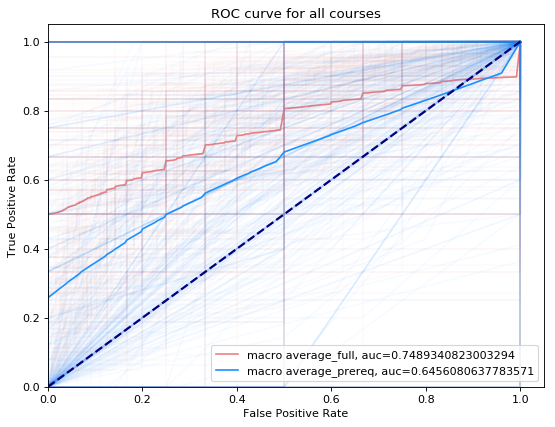

<Figure size 432x288 with 0 Axes>

In [19]:
from scipy import interp
from sklearn.metrics import auc
def plot_roc(full_results, prereq_results, pathname):
    plt.figure(0, figsize=(8, 6), dpi=80).clf()
    
    fpr_pos = len(full_results[0]) - 4
    tpr_pos = len(full_results[0]) - 3
    auc_pos = len(full_results[0]) - 1
    fpr = []
    tpr = []
    for i in range(len(full_results)):
        course_data = full_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='lightcoral', alpha=0.03)
    
    # Plot macro average for full
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(full_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(full_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(full_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average_full, auc="+str(roc_auc_macro), color='lightcoral', alpha=1)
    
    fpr = []
    tpr = []
    for i in range(len(prereq_results)):
        course_data = prereq_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='dodgerblue', alpha=0.03)

    
    # Plot macro average for prereq
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(prereq_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(prereq_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(prereq_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average_prereq, auc="+str(roc_auc_macro), color='dodgerblue', alpha=1)
    
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for all courses')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig("../results/" + PATHNAME + "_auc.png")
plot_roc(results_full, results_prereq, PATHNAME)

## Iterate on log reg models inc. official prereqs

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



672
673
674
675


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


764
765
766
767

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



768


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be

861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)



889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012


/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be 

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should b

/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/Users/Abood/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be 

    course_name  train_score  test_score  dev_score  train_groundtruth  \
0      PSYCH131     1.000000    0.500000   0.750000           0.464286   
1      MS&E245G     0.971429    0.600000   1.000000           0.685714   
2      PSYCH120     0.979592    0.571429   0.666667           0.387755   
3        CS205A     0.979167    1.000000   0.833333           0.416667   
4      ECON102C     0.979592    0.857143   0.833333           0.918367   
..          ...          ...         ...        ...                ...   
320       CS124     0.897878    0.821053   0.840426           0.847480   
321       CS109     0.811555    0.745690   0.688312           0.666307   
322       CS221     0.859862    0.744828   0.779310           0.717128   
323   PHYSICS43     0.853693    0.796610   0.823864           0.741477   
324      CS106A     0.701780    0.687204   0.717340           0.669436   

     test_groundtruth  dev_groundtruth  train_size  test_size  dev_size  \
0            0.250000         0.7500

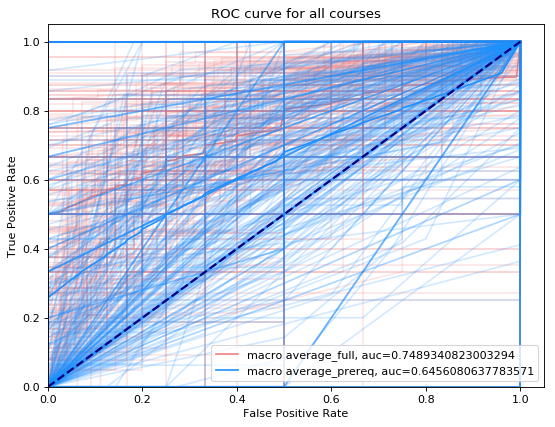

<Figure size 432x288 with 0 Axes>

In [14]:
LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
SUCCESS_GRADES = ["A+", "A", "A-", "B+"]
BMINUS_GRADES = ["A+", "A", "A-", "B+", "B", "B-"]

all_courses = set(raw_data["course_name"]) 

############# MODIFY THIS SECTION #############
courselist = all_courses

gender_param = True
gpa_param = False # currently crashes if set to True

x1grades_param = SUCCESS_GRADES
x1grades_shortname = "success" # short form for the filename
y1grades_param = SUCCESS_GRADES
y1grades_shortname = "success" # short form for the filename
limited_run = False
limit_count = 20
dev = True
###############################################

results_full = []
results_prereq = []
executor = ThreadPoolExecutor()
count = 0
for course_name in courselist:
    executor.submit(run_predictions_with_prereqs, course_name, results_full, results_prereq, TEST_QUARTERS, 
                                 gender_param, gpa_param, x1grades_param, y1grades_param, dev=dev)
    count += 1
    print(count)
    if limited_run:
        if count == limit_count:
            break
executor.shutdown()
results_full_df = pd.DataFrame(results_full, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"])
results_prereq_df = pd.DataFrame(results_prereq, columns = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"])

pprint(results_full_df)
pprint(results_prereq_df)

PATHNAME = "gender" + str(gender_param) + "_gpa" + str(gpa_param) + "_x1" + x1grades_shortname + "_y1" + y1grades_shortname

if dev:
    plot_roc(results_full, results_prereq, PATHNAME)

RESULTS_FULL_PATH = "../results/" + PATHNAME + "_full.fthr"
RESULTS_PREREQ_PATH = "../results/" + PATHNAME + "_prereq.fthr"
RESULTS_FULL_PATH_CSV = "../results/" + PATHNAME + "_full.csv"
RESULTS_PREREQ_PATH_CSV = "../results/" + PATHNAME + "_prereq.csv"
# results_full_df.to_feather(RESULTS_FULL_PATH)
# results_prereq_df.to_feather(RESULTS_PREREQ_PATH)
results_full_df.to_csv(RESULTS_FULL_PATH_CSV)
results_prereq_df.to_csv(RESULTS_PREREQ_PATH_CSV)

In [50]:
results_full_df.to_csv(RESULTS_FULL_PATH_CSV)
results_prereq_df.to_csv(RESULTS_PREREQ_PATH_CSV)

## LASSO logistic regression to reduce nonzero coefficients

In [ ]:
# TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

# def one_course_lasso(course_name, test_quarters = TEST_QUARTERS, gender = False, gpa= False, prereqSuccess = False):
#     X_train, X_test, y_train, y_test, fail_flag = get_and_split_data(course_name, test_quarters, gender, gpa = gpa, prereqSuccess = prereqSuccess)
#     for i in [10, 3, 1, 0.3, 0.1, 0.03, 0.01]:
#         model = LogisticRegression(penalty="l1", solver="saga", C=i, max_iter=1000) 
#         model.fit(X_train, y_train)
#         train_score = model.score(X_train, y_train)
#         test_score = model.score(X_test, y_test) 
#         print("\n***** C = {} *****".format(i))
#         print("training accuracy: {}, ground truth (proportion y = 1): {}".format(train_score, y_train.mean()))
#         print("test accuracy: {}, ground truth (proportion y = 1): {}".format(test_score, y_test.mean()))
        
#         coefs = [(X_train.columns[i], model.coef_[0][i]) for i in range(len(X_train.columns))]
#         coefs_pos = sorted(coefs, key = lambda x: x[1], reverse = True)
#         coefs_neg = sorted(coefs, key = lambda x: x[1], reverse = False)
#         coefs_abs = sorted(coefs, key = lambda x: abs(x[1]), reverse = True)
#         coefs_nonzero = sum([x[1] != 0 for x in coefs])
#         coefs_zero = sum(x[1] == 0 for x in coefs)
#         print("Number of nonzero/zero coefficients: {}/{}".format(coefs_nonzero, coefs_zero))
#         print("Largest absolute coefficients:")
#         pprint(coefs_abs[:3])
#         print("Largest positive coefficients:")
#         pprint(coefs_pos[:3])
#         print("Largest negative coefficients:")
#         pprint(coefs_neg[:3])